# Conditional GAN

GAN和WGAN都仅仅是从随机分布中“采样”出一个样本。生成这个样本的信息来源完全依赖于随机噪声，我们无法“控制”这个过程，比如（MNIST下）让生成器生成某一位数字。另外，由于生成器无法区分不同类别的生成样本，它可能生成一些和现实有较大差异的“无效样本”，比如生成一些“鬼画符”数字。Conditional GAN通过将条件信息引入生成器和判别器，可以指导生成器生成符合某个条件的数据。

原始GAN的生成器需要最小化生成分布$P_{\text{fake}} (x)$和真实分布$P_{\text{real}} (x)$之间的差异（JS散度、Wasserstein距离等）。与GAN不同，Conditional GAN建模的是给定条件$c$下，生成分布$P_{\text{fake}} (x\mid c)$和真实分布$P_{\text{real}} (x\mid c)$的差异。

* 对于JS散度，其损失函数变为

    $$
    \left\{
    \begin{aligned}
        \mathcal L_D(x, c) &= - \log D(x, c) - \log(1 - D(G(z, c), c)) \\
        \mathcal L_G(x, c) &= -\log D(G(z, c), c) \\
    \end{aligned}
    \right.
    $$

* 对于Wasserstein距离，其损失函数变为

    $$
    \left\{
    \begin{aligned}
        \mathcal L_D(x, c) &= - D(x, c) + D(G(z, c), c) \\
        \mathcal L_G(x, c) &= - D(G(z, c), c) \\
        \mathcal L_P(x, c) &= \left(\left\Vert\frac{\partial D(ux + (1 - u)G(z, c), c)}{\partial (ux + (1 - u)G(z, c))}\right\Vert_2 - 1\right)^2
    \end{aligned}
    \right.
    $$

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader

# SVG output
%config InlineBackend.figure_format = 'svg'

# Fix for certificate error
# https://stackoverflow.com/questions/71263622
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
train_dataset = torchvision.datasets.MNIST(
    train=True, root='data',
    transform=torchvision.transforms.ToTensor(), download=True
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

此处使用Wasserstein GAN，通过如下方式引入类别信息：

* 在生成器中引入一个128维的embedding作为类别输入，embedding后的向量与输入的随机噪声拼接，送入神经网络。
* 在判别器中引入一个784维的embedding，变形至$1\times 28\times 28$的维度后，作为输入图像的第二个通道。

In [3]:
class Reshape(torch.nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)


class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.classes = torch.nn.Embedding(10, 128)
        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(in_features=256, out_features=128 * 7 * 7),
            torch.nn.LeakyReLU(0.2),
            Reshape(128, 7, 7),
        )
        self.deconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.ConvTranspose2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(
                in_channels=128, out_channels=1, kernel_size=(3, 3), padding=(1, 1)
            ),
            torch.nn.Tanh(),
        )
        self.layers = torch.nn.Sequential(self.fcn, self.deconv)

    def forward(self, x, c):
        c_embedding = self.classes(c)
        x = torch.concatenate([x, c_embedding], dim=1)
        for layer in self.layers:
            x = layer(x)
        return x

class Critic(torch.nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.c_input = torch.nn.Sequential(
            torch.nn.Embedding(10, 784),
            Reshape(1, 28, 28)
        )
        self.x_input = torch.nn.Sequential(
            Reshape(1, 28, 28)
        )
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=2,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            Reshape(3136),
            torch.nn.Linear(in_features=3136, out_features=1)
        )

    def forward(self, x, c):
        x = self.x_input(x)
        c = self.c_input(c)
        x = self.conv(torch.concatenate([x, c], dim=1))
        return x.squeeze()

其余部分代码和WGAN保持一致。

In [4]:
from typing import Optional

class ConditionalWGAN(torch.nn.Module):
    def __init__(self):
        super(ConditionalWGAN, self).__init__()
        self.generator = Generator()
        self.critic = Critic()
        self.device = torch.device('cpu')

        for param in self.generator.parameters():
            torch.nn.init.normal_(param, mean=0, std=0.02)

    def to(self, *args, **kwargs):
        if args:
            self.device = args[0]
        elif 'device' in kwargs:
            self.device = kwargs['device']
        super().to(*args, **kwargs)

    def forward(self, c: torch.Tensor, x: Optional[torch.Tensor] = None):
        c = c.to(self.device)
        size = c.size(0)
        if x is None:
            assert size is not None
            z = torch.randn(size, 128, device=self.device)
            x = self.generator(z, c)
        else:
            size = x.size(0)
            x = x.to(self.device)
            x = x * 2 - 1

        y = self.critic(x, c)
        return x, y

    def penalty(self, x_real: torch.Tensor, x_fake: torch.Tensor, c: torch.Tensor):
        assert x_real.shape == x_fake.shape
        size = x_real.size(0)
        x_real = x_real.to(self.device)
        x_fake = x_fake.to(self.device)
        c = c.to(self.device)
        alpha = torch.rand(size, 1, 1, device=self.device)

        x_real = x_real.reshape(size, 28, 28)
        x_fake = x_fake.reshape(size, 28, 28)

        x_mid = (x_real * alpha + x_fake * (1 - alpha)).detach()
        x_mid.requires_grad_(True)
        y = self.critic(x_mid, c)

        gradients = torch.autograd.grad(
            outputs=y,
            inputs=x_mid,
            grad_outputs=torch.ones_like(y, device=self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        gradient_norm = gradients.view(size, -1).norm(2, dim=1)

        return (gradient_norm - 1) ** 2

model = ConditionalWGAN()

在没有训练时，每个类别只会输出随机噪声。

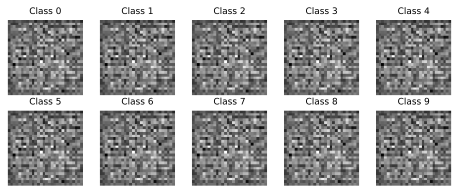

In [5]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from typing import Iterable


def plot_generator(z: torch.Tensor, c: torch.Tensor, model: ConditionalWGAN, ax: Optional[Axes] = None):
    z = z.to(model.device)
    c = c.to(model.device)
    with torch.no_grad():
        x = model.generator(z, c).view(28, 28).cpu().numpy() * 0.5 + 0.5

    if ax is None:
        plt.imshow(x, cmap='gray')
        plt.axis('off')
    else:
        ax.imshow(x, cmap='gray')
        ax.axis('off')

def plot_all_numbers(x: torch.Tensor, model: ConditionalWGAN, axes: Iterable[Axes]):
    c = torch.arange(0, 10, dtype=torch.long)
    for i, ax in enumerate(axes):
        plot_generator(x.reshape(1, -1), c[i].unsqueeze(0), model, ax)

x_noise = torch.randn(1, 128)
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
axes = ax.flatten()
plot_all_numbers(x_noise, model, axes)
for i, ax in enumerate(axes):
    ax.set_title(f'Class {i}', fontsize=9)
plt.show()

In [6]:
# Optimizer
optimizer_g = torch.optim.Adam(model.generator.parameters(), lr=2e-4)
optimizer_d = torch.optim.Adam(model.critic.parameters(), lr=2e-4)

# Hyper parameters
N = 120  # Number of epochs
alpha = 10  # Gradient penalty
K = 5  # Number of critic updates per generator update
device = 'cuda:5' if torch.cuda.is_available() else 'cpu'  # CUDA
model.to(device)

# Record training metrics
step = 0
train_metrics = []

训练模型，每隔10个epoch记录各个类别的生成器输出。

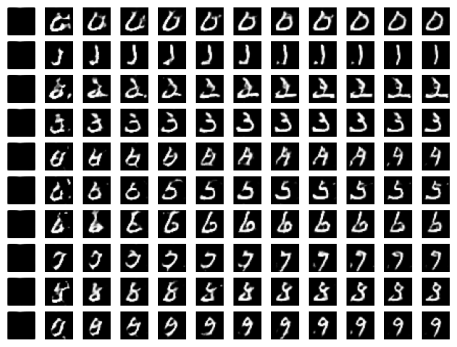

In [7]:
fig, ax = plt.subplots(10, N // 10, figsize=(8, 6))
axes = iter(ax.T)

for epoch in range(N):
    for i, (x, c) in enumerate(train_loader, start=0):
        model.train()
        step_metric = {}
        step += 1
        size = x.size(0)

        # Train critic
        # Fake sample
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        x_fake, y_fake = model(c)
        fake = y_fake.mean()
        fake.backward()
        step_metric['fake_score'] = fake.item()
        optimizer_d.step()

        # Real sample
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        _, y_real = model(c, x)
        real = -y_real.mean()
        step_metric['real_score'] = -(real.item())
        real.backward()
        optimizer_d.step()

        # Gradient penalty
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        penalty = model.penalty(x, x_fake, c).mean()
        step_metric['penalty'] = penalty.item()
        penalty = penalty * alpha
        penalty.backward()
        optimizer_d.step()

        # Train generator
        if step % K == 0:
            # Train generator
            optimizer_g.zero_grad()
            optimizer_d.zero_grad()
            x, y = model(c)
            loss_fake = -y.mean()
            loss_fake.backward()
            optimizer_g.step()

            step_metric['generator_score'] = -(loss_fake.item())

        train_metrics.append(step_metric)

    if (epoch + 1) % 10 == 0:
        model.eval()
        ax_nums = next(axes)
        plot_all_numbers(x_noise, model, ax_nums)

fig.show()

训练完成后，让模型生成若干组数字。从结果中可以发现，如果生成某个数字的质量很好，那么这个随机噪声所对应的其他类别的输出质量也会较好，反之亦然。

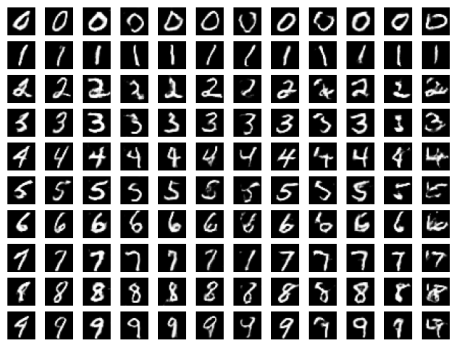

In [8]:
model.eval()
x_noise = torch.randn(12, 128)
fig, ax = plt.subplots(10, 12, figsize=(8, 6))
ax = ax.T

for i in range(12):
    plot_all_numbers(x_noise[i], model, ax[i])
plt.show()

In [9]:
from typing import Any, Dict, Iterable, List, Tuple
import random

def extract_metrics(data: List[Dict[str, Any]], field: str) -> Tuple[List[int], List[Any]]:
    x, y = [], []
    for step, record in enumerate(data, start=1):
        if field in record:
            x.append(step)
            y.append(record[field])
    return x, y

def ema(x, beta):
    y = x[0]
    for _ in x:
        y = beta * y + (1 - beta) * _
        yield y

def sample(x: Iterable[Any], y: Iterable[Any], ratio: float):
    result_x, result_y = [], []
    for x_sample, y_sample in zip(x, y):
        if random.random() < ratio:
            result_x.append(x_sample)
            result_y.append(y_sample)
    return result_x, result_y

绘制训练过程中判别器对真实样本和生成样本的输出、生成分布和真实分布的Wasserstein距离，以及1-Lipschitz约束的满足情况。

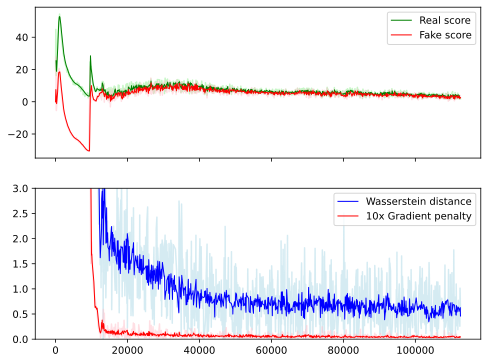

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

x_real_score, y_real_score = extract_metrics(train_metrics, 'real_score')
x_fake_score, y_fake_score = extract_metrics(train_metrics, 'fake_score')
x_penalty, y_penalty = extract_metrics(train_metrics, 'penalty')
y_penalty = [alpha * _ for _ in y_penalty]

# Wasserstein distance
x_diff, y_diff = zip(*[
    (x_real, real - fake)
    for x_real, real, x_fake, fake
        in zip(x_real_score, y_real_score, x_fake_score, y_fake_score)
    if x_real == x_fake
])

ax1.plot(*sample(x_real_score, y_real_score, 0.01), color='lightgreen', alpha=0.5)
ax1.plot(*sample(x_fake_score, y_fake_score, 0.01), color='pink', alpha=0.5)
ax2.plot(*sample(x_diff, y_diff, 0.01), color='lightblue', alpha=0.5)
ax2.plot(*sample(x_penalty, y_penalty, 0.01), color='pink', alpha=0.5)

ax1.plot(*sample(x_real_score, ema(y_real_score, 0.99), 0.01), label='Real score', color='green', linewidth=1)
ax1.plot(*sample(x_fake_score, ema(y_fake_score, 0.99), 0.01), label='Fake score', color='red', linewidth=1)
ax2.plot(*sample(x_diff, ema(y_diff, 0.99), 0.01), label='Wasserstein distance', color='blue', linewidth=1)
ax2.plot(*sample(x_diff, ema(y_penalty, 0.99), 0.01), label=f'{alpha}x Gradient penalty', color='red', linewidth=1)

ax2.set_ylim(0, 3)
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

fig.show()